In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.fft 
import pmdarima as pm
import itertools
import statsmodels.api as sm
import datetime
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.sarimax import SARIMAX


os.chdir('/home/etienne/data/spikes')
spikes3=pd.read_csv('spikesrat3.csv')

In [2]:
import cv2
def window(spikes,delta):
    '''
    Entry: number of spikes per hour
           delta which is the number of time points chosen to average
           
    Return: the unweighted downsampled temporal network of new size (time points)/delta
    '''
    Filter=np.ones((delta,))

    m=np.convolve(spikes,Filter,mode='valid')[::delta]
    return(m)

In [15]:
def optimize_SARIMA(parameters_list, d, D, s,endog, exog=None):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(endog,exog=exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [4]:
spikes=np.array(spikes3)[:,0]
delta=24

Filter=np.ones((delta,))/delta

spikespd=window(spikes,delta)

In [5]:
from scipy.signal import sosfiltfilt,butter

spikesph=spikes[240:]
spikesphr=spikes[240:-240]
signalt=spikespd[10:]

fh=1/96*2

filtre=butter(10,[fh],'low',output='sos')

spkf=sosfiltfilt(filtre,spikesph)
spkfr=sosfiltfilt(filtre,spikesphr)

<BarContainer object of 56 artists>

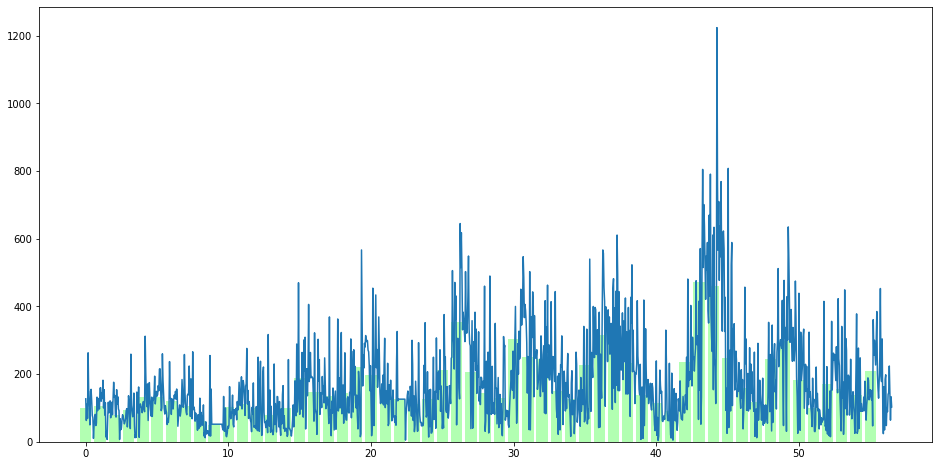

In [6]:
plt.figure(figsize=(16,8))

plt.plot(np.arange(len(spkf))/24,spikesph)
#plt.scatter(np.arange(len(spkf[::6]))/4,(spkf[::6]))
#plt.plot(np.arange(len(spkf))/24,(spikes[240:]))
plt.bar(np.arange(56),signalt/24,color=(0,1,0,0.3))

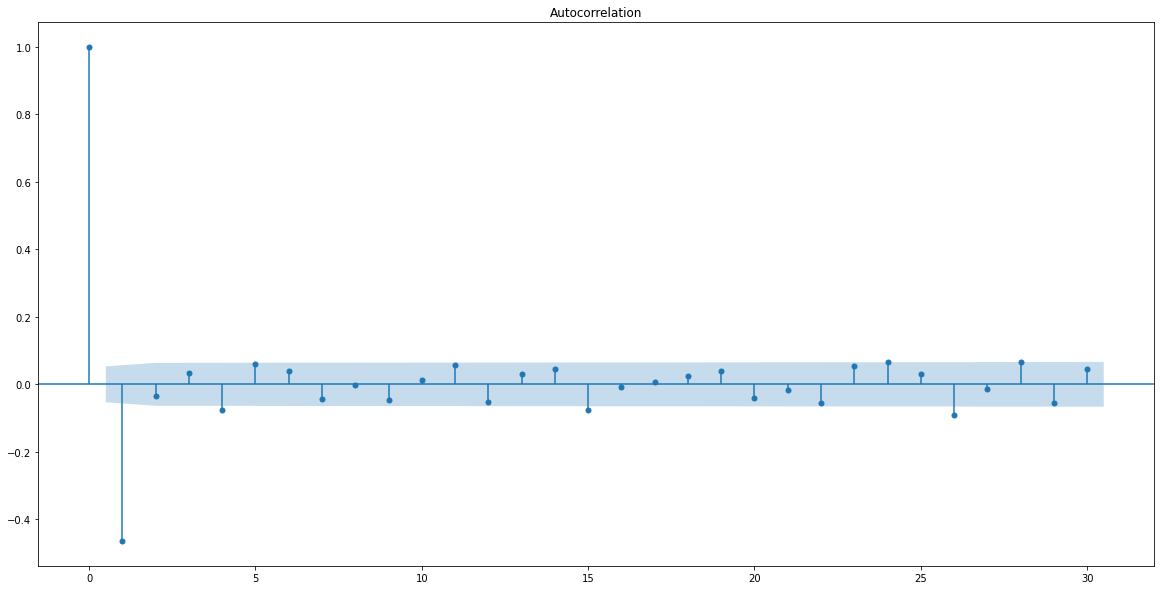

In [8]:
from pmdarima.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics import tsaplots
plt.rc("figure", figsize=(20,10))
tsaplots.plot_acf(np.diff(spikesph),lags=30)
plt.show()

In [8]:
from itertools import product

p = range(1, 6, 1)
d = 1
q = range(1, 4, 1)
P = range(1, 6, 1)
D = 1
Q = range(1, 4, 1)
s = 12
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))


225


In [12]:
spikesphr.shape

(1117,)

In [16]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 12,spikesphr )


<ipython-input-15-1245dc0f04f4>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


  0%|          | 0/225 [00:00<?, ?it/s]

/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: Convergence

In [17]:
result_df

,"(p,q)x(P,Q)",AIC
0,"(1, 2, 2, 2)",16.000000
1,"(1, 1, 4, 3)",13432.429082
2,"(5, 3, 4, 3)",13432.595181
3,"(2, 1, 4, 3)",13434.823137
4,"(3, 1, 4, 3)",13437.004022
...,...,...
217,"(4, 1, 1, 1)",13529.442249
218,"(5, 2, 5, 1)",13550.849799
219,"(4, 3, 4, 2)",13551.979688
220,"(4, 3, 3, 1)",13649.689343


In [28]:
arima_model=SARIMAX(spikesphr,order=(5,1,3),seasonal_order=(4,1,3,12))
arima_fit=arima_model.fit()

/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [29]:
yhat = arima_fit.predict(0,len(spikesphr)+240)

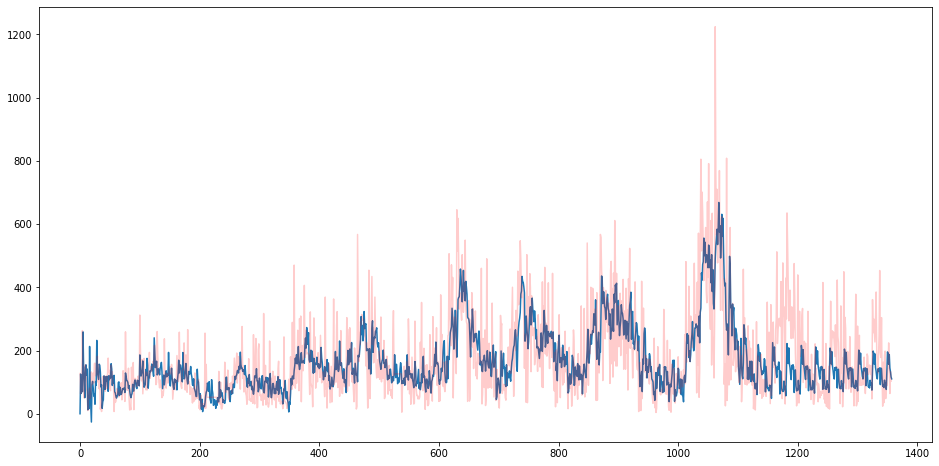

In [30]:
plt.figure(figsize=(16,8))
plt.plot(yhat)
plt.plot(spikesph,c=(1,0,0,0.2))

In [31]:
f0=0.0025
f1=1/24
ntest=240
exog = pd.DataFrame()

exog['f0s'] = np.sin(2 * np.pi * np.arange(len(spikesphr)+ntest) *3*f0-24)
exog['f0c'] = np.cos(2 * np.pi * np.arange(len(spikesphr)+ntest) *3*f0-24)
exog['f1s'] = np.sin(2 * np.pi * np.arange(len(spikesphr)+ntest) *f1)
exog['f1c'] = np.cos(2 * np.pi * np.arange(len(spikesphr)+ntest) *f1)
exog_tr=exog.iloc[:-ntest]
exog_t=exog[-ntest:]

In [37]:
arima_model_fourrier=SARIMAX(spikesphr,order=(5,1,2),seasonal_order=(4,1,3,12),exog=exog_tr)
arima_fit_fourrier=arima_model_fourrier.fit()

/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [34]:
from itertools import product

p = range(2, 6, 1)
d = 1
q = range(1, 4, 1)
P = range(2, 6, 1)
D = 1
Q = range(2, 5, 1)
s = 12
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))


144


In [35]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 12,spikesphr,exog=exog_tr )


<ipython-input-15-1245dc0f04f4>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for param in tqdm_notebook(parameters_list):


  0%|          | 0/144 [00:00<?, ?it/s]

/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/etienne/env/lib/python3.8/site-packages/statsmodels/base/model.py:566: Convergence

In [36]:
result_df

,"(p,q)x(P,Q)",AIC
0,"(5, 2, 4, 3)",13427.882307
1,"(2, 1, 4, 3)",13430.165073
2,"(3, 1, 4, 3)",13431.422763
3,"(2, 2, 4, 3)",13435.007915
4,"(2, 3, 4, 3)",13435.215302
...,...,...
130,"(4, 3, 3, 4)",13585.773398
131,"(4, 3, 4, 4)",13625.851995
132,"(4, 3, 5, 4)",13638.812645
133,"(5, 3, 3, 4)",13653.427103


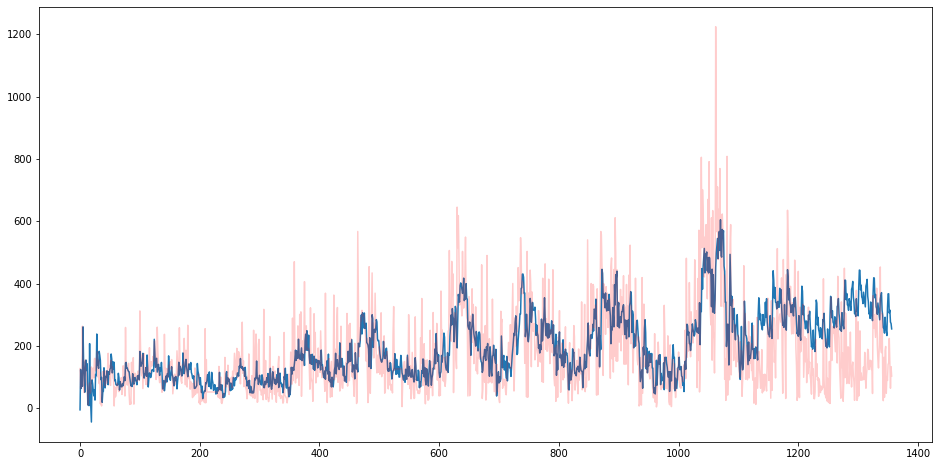

In [38]:
yhat = arima_fit_fourrier.predict(0,len(spikesphr)+239,exog=exog_t)
plt.figure(figsize=(16,8))
plt.plot(yhat)
plt.plot(spikesph,c=(1,0,0,0.2))

In [ ]:
#rolling_forecast

<BarContainer object of 56 artists>

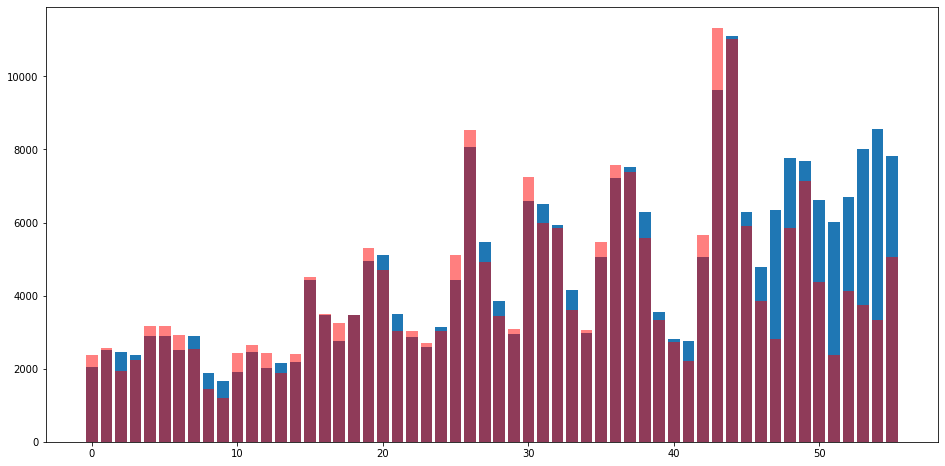

In [42]:
spikespd_forecasted=window(yhat,delta)

plt.figure(figsize=(16,8))
plt.bar(np.arange(len(spikespd_forecasted)),spikespd_forecasted)
plt.bar(np.arange(len(spikespd[10:])),spikespd[10:],color=(1,0,0,0.5))

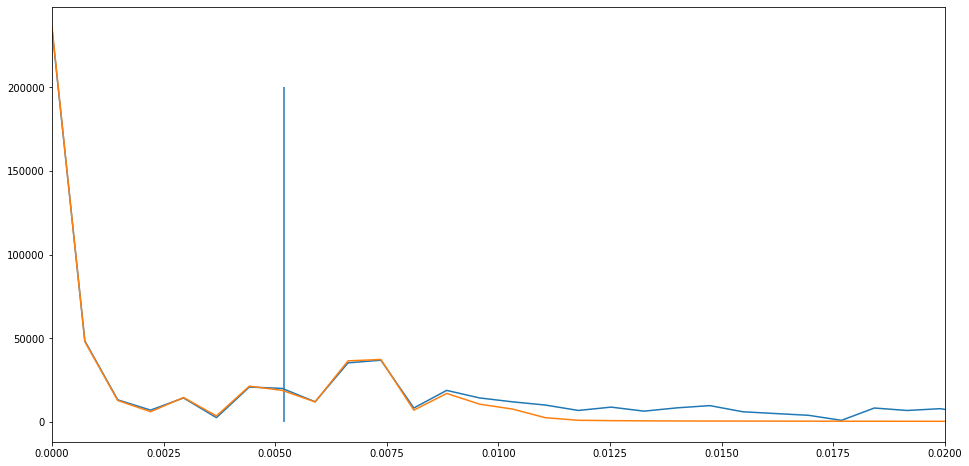

In [146]:
from scipy.fft import fft, fftfreq, fftshift

DFT=fft(spikesph)
sp=fftshift(DFT)
freq = fftshift(fftfreq(spikesph.shape[-1]))

DFTr=fft(spkf)
spr=fftshift(DFTr)
freqr = fftshift(fftfreq(spkf.shape[-1]))


plt.figure(figsize=(16,8))
plt.plot(freq, np.sqrt((sp.imag)**2 +(sp.real)**2))
plt.plot(freqr, np.sqrt((spr.imag)**2 +(spr.real)**2))

plt.xlim((0,0.02))

plt.vlines(2/(24*16),0,200000)

In [289]:
datelist=[]
ndays=4
lag=6

signal=spkfr[:-ndays*24][::6]

timedelta=datetime.timedelta(hours=lag)
date0=datetime.datetime(2015, 8, 9,16, minute=0, second=0, microsecond=0)

for k in range(len(signal)):
    date=date0+k*timedelta
    datelist.append(date)
    
    
df = pd.DataFrame([datelist,signal], ['ds','y']).T
df.set_index('ds',inplace=True)

In [303]:
df.shape

(171, 1)

In [328]:
arima_model=auto_arima(df.y,start_p=6,max_p=25,stationary=False,seasonal=True,m=24)
arima_model.fit(df.y)
